In [1]:
import numpy as np
from rbm import RBM
import matplotlib.pyplot as plt
%matplotlib inline

Load training and validation data:

In [2]:
train_set = np.loadtxt('../c++/training_data.txt')
target_psi = np.loadtxt('../c++/target_psi.txt')

train_set.shape

(10000, 10)

Initialize the RBM with the same number of hidden and visible units:

In [3]:
rbm = RBM(num_visible=train_set.shape[-1],
          num_hidden=train_set.shape[-1],
          seed=1234)

We'll train the RBM for 200 epochs with a batch size of 25. During training we'll record the overlap and average negative log likelihood of the model against the validation data every 10 epochs.

For reference, the formula for the overlap is as follows:

$$\sum_\vec{v} \psi\left(\vec{v}\right)\sqrt{p\left(\vec{v}\right)}$$

This is essentially an estimate of the sum over the entire probability mass function defined by $\psi^2$. Thus, we want it to be close $1$.

First, we'll take a look at the RBM.train method's documentation:

In [4]:
help(rbm.train)

Help on method train in module rbm:

train(data, target, epochs, batch_size, k=1, persistent=False, persist_from=0, lr=0.001, momentum=0.9, method='sgd', l1_reg=0, l2_reg=0, log_every=10, progbar=False, **kwargs) method of rbm.RBM instance
    Train the RBM
    
    data -- the training data
    target -- the validation data (wavefunction values)
    epochs -- number of epochs to train for
    batch_size -- size of each mini-batch
    k -- number of Contrastive Divergence steps (default 1)
    persistent -- whether to use PCD as opposed to CD
                  (default False)
    persist_from -- use CD first then start using PCD after
                    this many epochs; ignored if `persistent`
                    is False (default 0)
    lr -- the learning rate; can be a float or a function that
          takes the epoch number and returns a float (default 1e-3)
    momentum -- the momentum parameter; can be a float or a
          function that takes the epoch number and returns
    

In [5]:
log_every = 10 # log and record validation metrics every 10 epochs
nll_list, overlap_list = rbm.train(train_set, target_psi, 
                                   epochs=200,
                                   batch_size=25, 
                                   k=3,
                                   lr=(lambda ep: 0.1 if ep < 100 else 1e-4), 
                                   l1_reg=0, 
                                   l2_reg=0,
                                   method="sgd",
                                   log_every=log_every,
                                   progbar=False)

Epoch =    0; NLL per training example =   7.46581103; Overlap =   0.49697722
Epoch =   10; NLL per training example =   4.59784933; Overlap =   0.98055360
Epoch =   20; NLL per training example =   4.55782278; Overlap =   0.98951308
Epoch =   30; NLL per training example =   4.56248325; Overlap =   0.98815823
Epoch =   40; NLL per training example =   4.60590591; Overlap =   0.97869122
Epoch =   50; NLL per training example =   4.56020164; Overlap =   0.98902553
Epoch =   60; NLL per training example =   4.55404177; Overlap =   0.98922637
Epoch =   70; NLL per training example =   4.63949484; Overlap =   0.97081105
Epoch =   80; NLL per training example =   4.54972841; Overlap =   0.98983613
Epoch =   90; NLL per training example =   4.56783523; Overlap =   0.98558907
Epoch =  100; NLL per training example =   4.52903160; Overlap =   0.99592382
Epoch =  110; NLL per training example =   4.52660564; Overlap =   0.99648050
Epoch =  120; NLL per training example =   4.52494968; Overlap =

Let's see how the average negative log likelihood and the overlap changed during training:

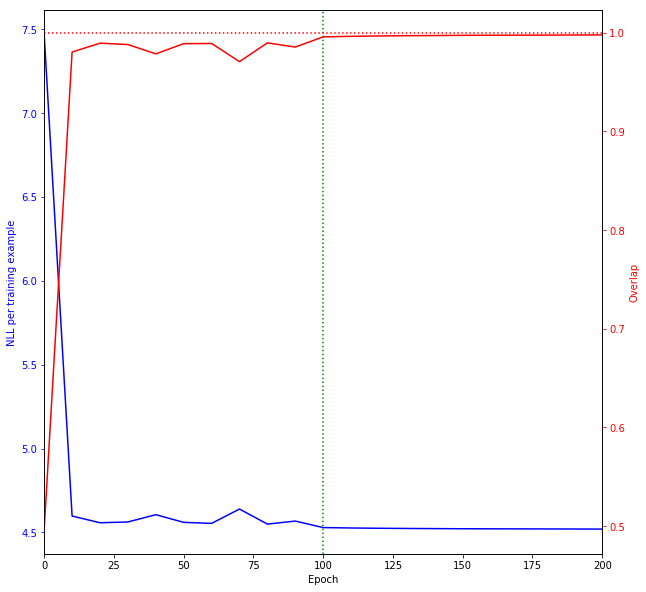

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.plot(log_every * np.arange(len(nll_list)), np.array(nll_list) / len(train_set), 'b')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("NLL per training example", color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlim(0, log_every * (len(nll_list)-1))
ax1.axvline(x=100, linestyle=':', color='g') # plot when the learning rate switches

ax2 = ax1.twinx()
ax2.plot(log_every * np.arange(len(overlap_list)), overlap_list, 'r')
ax2.set_ylabel('Overlap', color='r')
ax2.tick_params('y', colors='r')
ax2.axhline(y=1, xmin=0, xmax=len(overlap_list), linestyle=':', color='r') # maximum overlap

plt.show()

We can also save the model for later use. Note that the model's internal random state is also saved along with the weights and biases, thus we can expect the saved RBM to produce the exact same sampled as the RBM currently in use.

In [7]:
rbm.save("./demo_model.npz")

We load the model like so:

In [8]:
new_rbm = RBM.load("./demo_model.npz")

Sample both the original and the loaded RBM:

In [9]:
sample1 = rbm.sample(k=100, n_samples=10) 
sample2 = new_rbm.sample(k=100, n_samples=10)
sample1, sample2

(array([[1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 1., 0., 0., 0.]], dtype=float32),
 array([[1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 

In [10]:
np.array_equal(sample1, sample2)

True